In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import os
import json
import seaborn as sns
import networkx as nx
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
from matplotlib import pyplot as plt
import torch
import os
import numpy as np
from sklearn.metrics import pairwise_distances


In [2]:
PATH_METHYLATION = "/work/h2020deciderficarra_shared/TCGA/OV/project_n16_data/Methylation"
FILE_PATH_DICT = "../case_id_and_structure.json"
FILE_PATH_CONVERTER = "matched_cpg_genes.csv"
FILE_PATH_DATASTRUCTURE_CONVERTED = 'datastructure_converted.csv'
NUMBER_OF_VALUES = 1000

In [3]:
# Load the file path dictionary
with open(FILE_PATH_DICT, 'r') as file:
    file_parsed = json.load(file)

# Create dictionaries for case_id and os
file_to_case_id = {file_parsed[k]['files']['methylation']: k for k in file_parsed.keys()}
file_to_os = {file_parsed[k]['files']['methylation']: file_parsed[k]['os'] for k in file_parsed.keys()}

In [4]:
print(file_to_case_id)

{'c0c6191b-f9c0-4e33-8a20-1684230f5182.methylation_array.sesame.level3betas.txt': 'b3511675-fd68-4745-8020-e290ca0fd115', 'ae54509f-5df9-4bae-9d39-a03ca716968c.methylation_array.sesame.level3betas.txt': '4261267c-7042-4c6e-83ed-12fb401003fc', 'fb6f82c3-82bd-4af1-9f37-2cf868a84017.methylation_array.sesame.level3betas.txt': 'b7715ff6-57a6-4513-9447-aa8bc93f16d4', '5cf52e1d-a1df-4911-8496-6672232f43b0.methylation_array.sesame.level3betas.txt': '5d7027f5-60a0-47ab-a79d-667c9acc0e54', '9855b9f1-6c59-4fe1-ba86-8fd94a95f63c.methylation_array.sesame.level3betas.txt': '28ed2d42-5b4c-4bca-b2b2-6b2a6d3c42cf', '514cebe3-a634-4b78-9f46-09cd7e533de6.methylation_array.sesame.level3betas.txt': '7dcc809b-e33a-4453-b92a-c00786f48cb0', '4825da66-2f6b-4ba4-ad21-70a31bbf181e.methylation_array.sesame.level3betas.txt': '611600a6-43ec-4029-9682-cd6d6a3312ec', 'c55c3cf6-4566-4d65-a45d-3d4206c05de9.methylation_array.sesame.level3betas.txt': 'f8a5547f-f1bc-4c01-8b68-25b5ee0caeab', '2a2d315e-15a8-468d-b6d9-b306f9

In [5]:
# Initialize the DataFrame
datastructure = pd.DataFrame(columns=['case_id', 'os','methylation_id','methylation_values'])

index = 0
for root, dirs, files in os.walk(PATH_METHYLATION):
    for dir in dirs:
        for root, dirs, files in os.walk(os.path.join(PATH_METHYLATION, dir)):
            for file in files:
                if file in file_to_case_id.keys():
                    parsed_file = pd.read_csv(os.path.join(PATH_METHYLATION, dir, file),
                                              sep='\t', header=None, names=["id", "methylation"])
                    parsed_file = parsed_file[['id', 'methylation']]
                    parsed_file = parsed_file.astype({'methylation': float, 'id': str})

                    # Extract methylation values
                    methylation_id = parsed_file['id'].tolist()
                    methylation_values = parsed_file['methylation'].tolist()

                    # Add the data to the DataFrame
                    datastructure.loc[index] = [
                        file_to_case_id[file],
                        file_to_os[file],
                        methylation_id,
                        methylation_values
                    ]
                    index += 1


In [6]:
print(datastructure)

                                  case_id    os  \
0    dc5a6ce7-01e5-408d-812e-e3e0ddc1cde5   629   
1    5d1a54fe-e0df-4c17-b623-b649a136dc82  1688   
2    d2c0d320-d1c5-4eed-af4f-15540e60db0b  1189   
3    e641aed9-1dd8-4c30-b231-f12b20a76df0   788   
4    afd92922-b8dc-48bd-a9c0-bc8d95855eb7  1341   
..                                    ...   ...   
221  cf1e86ec-4bcb-403c-831b-d67bddef14eb   312   
222  28ed2d42-5b4c-4bca-b2b2-6b2a6d3c42cf    25   
223  65435f50-a35d-49e3-a36e-b95d9e274ca0  2688   
224  062982f8-9f49-425a-99e9-008af5ed9040   857   
225  08c64000-d320-4e4d-974b-da503d48890c  1767   

                                        methylation_id  \
0    [cg00000292, cg00002426, cg00003994, cg0000584...   
1    [cg00000292, cg00002426, cg00003994, cg0000584...   
2    [cg00000292, cg00002426, cg00003994, cg0000584...   
3    [cg00000292, cg00002426, cg00003994, cg0000584...   
4    [cg00000292, cg00002426, cg00003994, cg0000584...   
..                                     

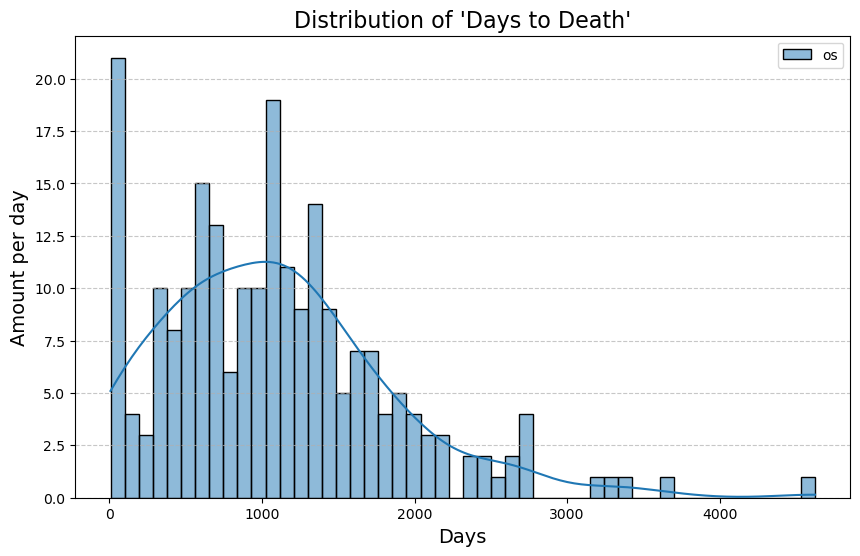

In [7]:
plt.figure(figsize=(10, 6))
sns.histplot(datastructure, bins=50, kde=True, color="red")
plt.title("Distribution of \'Days to Death\'", fontsize=16)
plt.xlabel("Days", fontsize=14)
plt.ylabel("Amount per day", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [8]:
# Carica il file di conversione
conversion_df = pd.read_csv(FILE_PATH_CONVERTER)

# Crea un dizionario per la conversione rapida
conversion_dict = pd.Series(conversion_df.gene_id.values, index=conversion_df.cpg_IlmnID).to_dict()

# Funzione per convertire methylation_id in gene_id utilizzando il dizionario
def convert_methylation_to_gene(methylation_ids, conversion_dict):
    return [conversion_dict.get(methylation_id, None) for methylation_id in methylation_ids]

# Crea una nuova colonna 'gene_id' nel DataFrame
datastructure['gene_id'] = datastructure['methylation_id'].apply(lambda x: convert_methylation_to_gene(x, conversion_dict))

print(datastructure)

/tmp/ipykernel_1347822/686524669.py:2: DtypeWarning: Columns (1,7) have mixed types. Specify dtype option on import or set low_memory=False.
  conversion_df = pd.read_csv(FILE_PATH_CONVERTER)


                                  case_id    os  \
0    dc5a6ce7-01e5-408d-812e-e3e0ddc1cde5   629   
1    5d1a54fe-e0df-4c17-b623-b649a136dc82  1688   
2    d2c0d320-d1c5-4eed-af4f-15540e60db0b  1189   
3    e641aed9-1dd8-4c30-b231-f12b20a76df0   788   
4    afd92922-b8dc-48bd-a9c0-bc8d95855eb7  1341   
..                                    ...   ...   
221  cf1e86ec-4bcb-403c-831b-d67bddef14eb   312   
222  28ed2d42-5b4c-4bca-b2b2-6b2a6d3c42cf    25   
223  65435f50-a35d-49e3-a36e-b95d9e274ca0  2688   
224  062982f8-9f49-425a-99e9-008af5ed9040   857   
225  08c64000-d320-4e4d-974b-da503d48890c  1767   

                                        methylation_id  \
0    [cg00000292, cg00002426, cg00003994, cg0000584...   
1    [cg00000292, cg00002426, cg00003994, cg0000584...   
2    [cg00000292, cg00002426, cg00003994, cg0000584...   
3    [cg00000292, cg00002426, cg00003994, cg0000584...   
4    [cg00000292, cg00002426, cg00003994, cg0000584...   
..                                     

In [9]:
# Calcolo della varianza per ogni lista in methylation_values
datastructure['methylation_variance'] = datastructure['methylation_values'].apply(lambda x: pd.Series(x).var())

# Trova le prime mille posizioni dei valori con la varianza più alta
max_variance_positions = datastructure['methylation_values'].apply(lambda x: pd.Series(x).nlargest(10000).index.tolist())

# Creazione di un nuovo DataFrame con solo i valori nelle posizioni elencate
df_variance = {
    'case_id': datastructure['case_id'],
    'os': datastructure['os'],
    'methylation_id': datastructure.apply(lambda row: [row['methylation_id'][i] for i in max_variance_positions[row.name]], axis=1),
    'methylation_values': datastructure.apply(lambda row: [row['methylation_values'][i] for i in max_variance_positions[row.name]], axis=1),
    'gene_id': datastructure.apply(lambda row: [row['gene_id'][i] for i in max_variance_positions[row.name]], axis=1),
    'methylation_variance': datastructure['methylation_variance']  # Aggiungi methylation_variance al DataFrame
}

df_variance = pd.DataFrame(df_variance)

# Ordinamento del DataFrame in base alla varianza in ordine decrescente
df_variance = df_variance.sort_values(by='methylation_variance', ascending=False)

print("Nuovo DataFrame con solo i valori nelle posizioni elencate:")
print(df_variance)
#print(df_variance.info())

Nuovo DataFrame con solo i valori nelle posizioni elencate:
                                  case_id    os  \
127  17181157-c9e2-4bd6-8653-f5dce56f9053  1354   
163  778ce436-a825-4689-81c1-b7c965404163  1875   
29   5d603bba-62e6-48fb-b8fc-401109abcaee  1103   
179  88180134-710f-46ea-9b06-5e5d860d6d9f  1354   
32   6b06281b-d3a9-440e-a86c-ee7db003352a  1448   
..                                    ...   ...   
57   7ca97692-0bf5-4bbd-81ce-10a051d04bd5   636   
126  ad2b1a0a-153f-483d-b228-5763eba3f6cc   608   
218  384170fc-e8be-426a-a54e-bf1ca61f2986   583   
189  80f85c54-e12f-4afa-8fa5-5f3e083b6f95  1024   
80   2517ca7a-6057-4c19-b7e1-f6d078e9881a  1059   

                                        methylation_id  \
127  [cg07740640, cg26208930, cg07851192, cg0119444...   
163  [cg23401756, cg20483763, cg21430666, cg1820245...   
29   [cg20483763, cg02723533, cg23401756, cg1958495...   
179  [cg26208930, cg20483763, cg21430666, cg0272353...   
32   [cg10107671, cg02723533, cg25178

In [10]:
# Funzione per rimuovere i valori None dalle liste e le posizioni corrispondenti in altre colonne
def remove_none_and_corresponding_positions(df):
    # Trova le posizioni dei valori None in gene_id
    none_positions = df['gene_id'].apply(lambda x: [i for i, value in enumerate(x) if value is None])

    # Rimuovi i valori None da gene_id e le posizioni corrispondenti da methylation_id e methylation_values
    df['gene_id'] = df['gene_id'].apply(lambda x: [value for value in x if value is not None])
    df['methylation_id'] = df.apply(lambda row: [value for i, value in enumerate(row['methylation_id']) if i not in none_positions[row.name]], axis=1)
    df['methylation_values'] = df.apply(lambda row: [value for i, value in enumerate(row['methylation_values']) if i not in none_positions[row.name]], axis=1)

    return df

# Applica la funzione al DataFrame
df_variance = remove_none_and_corresponding_positions(df_variance)

# Rimuovi le righe dove la lista gene_id è vuota dopo aver rimosso i valori None
df_variance = df_variance[df_variance['gene_id'].map(len) > 0]

print("Nuovo DataFrame con solo i valori nelle posizioni elencate:")
print(df_variance)

Nuovo DataFrame con solo i valori nelle posizioni elencate:
                                  case_id    os  \
127  17181157-c9e2-4bd6-8653-f5dce56f9053  1354   
163  778ce436-a825-4689-81c1-b7c965404163  1875   
29   5d603bba-62e6-48fb-b8fc-401109abcaee  1103   
179  88180134-710f-46ea-9b06-5e5d860d6d9f  1354   
32   6b06281b-d3a9-440e-a86c-ee7db003352a  1448   
..                                    ...   ...   
57   7ca97692-0bf5-4bbd-81ce-10a051d04bd5   636   
126  ad2b1a0a-153f-483d-b228-5763eba3f6cc   608   
218  384170fc-e8be-426a-a54e-bf1ca61f2986   583   
189  80f85c54-e12f-4afa-8fa5-5f3e083b6f95  1024   
80   2517ca7a-6057-4c19-b7e1-f6d078e9881a  1059   

                                        methylation_id  \
127  [cg21430666, cg23366752, cg15142488, cg2565198...   
163  [cg21430666, cg15142488, cg09996240, cg2336675...   
29   [cg21430666, cg15142488, cg18135555, cg1718816...   
179  [cg21430666, cg15142488, cg27651218, cg2626756...   
32   [cg04382920, cg00062776, cg15142

In [11]:
# Creazione di un nuovo DataFrame con i 2000 valori con varianza più alta da df_variance
top_data = {
    'case_id': df_variance['case_id'],
    'os': df_variance['os'],
    'methylation_id': df_variance['methylation_id'].apply(lambda x: x[:NUMBER_OF_VALUES]),
    'methylation_values': df_variance['methylation_values'].apply(lambda x: x[:NUMBER_OF_VALUES]),
    'gene_id': df_variance['gene_id'].apply(lambda x: x[:NUMBER_OF_VALUES]),
    'methylation_variance': df_variance['methylation_variance']  # Mantieni methylation_variance nel nuovo DataFrame
}

df = pd.DataFrame(top_data)

print("Nuovo DataFrame con i 2000 valori con varianza più alta:")
print(df)

Nuovo DataFrame con i 2000 valori con varianza più alta:
                                  case_id    os  \
127  17181157-c9e2-4bd6-8653-f5dce56f9053  1354   
163  778ce436-a825-4689-81c1-b7c965404163  1875   
29   5d603bba-62e6-48fb-b8fc-401109abcaee  1103   
179  88180134-710f-46ea-9b06-5e5d860d6d9f  1354   
32   6b06281b-d3a9-440e-a86c-ee7db003352a  1448   
..                                    ...   ...   
57   7ca97692-0bf5-4bbd-81ce-10a051d04bd5   636   
126  ad2b1a0a-153f-483d-b228-5763eba3f6cc   608   
218  384170fc-e8be-426a-a54e-bf1ca61f2986   583   
189  80f85c54-e12f-4afa-8fa5-5f3e083b6f95  1024   
80   2517ca7a-6057-4c19-b7e1-f6d078e9881a  1059   

                                        methylation_id  \
127  [cg21430666, cg23366752, cg15142488, cg2565198...   
163  [cg21430666, cg15142488, cg09996240, cg2336675...   
29   [cg21430666, cg15142488, cg18135555, cg1718816...   
179  [cg21430666, cg15142488, cg27651218, cg2626756...   
32   [cg04382920, cg00062776, cg15142488

In [12]:
# Ordina il DataFrame per varianza in ordine decrescente
df_sorted = df.sort_values(by='methylation_variance', ascending=False)

# Estrai la colonna gene_id in ordine ordinato
sorted_gene_ids = df_sorted['gene_id'].tolist()

# Salva i gene_id ordinati in un file JSON
with open('sorted_gene_ids_methylation.json', 'w') as f:
    json.dump(sorted_gene_ids, f)

print("Gene IDs ordinati salvati in sorted_gene_ids_methylation.json")

Gene IDs ordinati salvati in sorted_gene_ids_methylation.json


In [16]:
df.to_csv(FILE_PATH_DATASTRUCTURE_CONVERTED, index=False)

Media della metilazione: 0.7752549734827315
Mediana della metilazione: 0.827277003571371


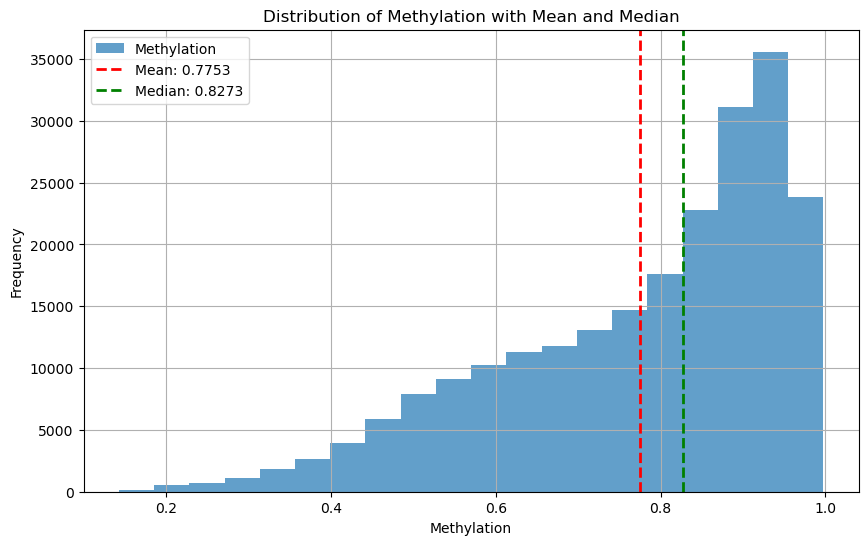

In [13]:
# Creiamo una lista per contenere tutti i valori di metilazione
all_methylation_values = []

# Itera attraverso il DataFrame e aggiungi i valori di metilazione alla lista
for index, row in df.iterrows():
    methylation_values = row['methylation_values']
    all_methylation_values.extend(methylation_values)

# Calcola la media e la mediana
mean_methylation = pd.Series(all_methylation_values).mean()
median_methylation = pd.Series(all_methylation_values).median()

print("Media della metilazione:", mean_methylation)
print("Mediana della metilazione:", median_methylation)

# Rappresenta la media e la mediana in un grafico
plt.figure(figsize=(10, 6))
plt.hist(all_methylation_values, bins=20, alpha=0.7, label='Methylation')
plt.axvline(mean_methylation, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean_methylation:.4f}')
plt.axvline(median_methylation, color='g', linestyle='dashed', linewidth=2, label=f'Median: {median_methylation:.4f}')
plt.xlabel('Methylation')
plt.ylabel('Frequency')
plt.title('Distribution of Methylation with Mean and Median')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
THRESHOLD = median_methylation

list_of_Data = []
methylation_data = df['methylation_values'].values
feature_size = methylation_data.shape[0]
edges = [[], []]

# Calcola la matrice delle distanze
dist_matrix = np.zeros((feature_size, feature_size))
for i in range(feature_size):
    for j in range(i + 1, feature_size):
        dist_matrix[i, j] = np.linalg.norm(np.array(methylation_data[i]) - np.array(methylation_data[j]))

# Trova gli indici dove la similarità è inferiore o uguale alla soglia
f_1_indices, f_2_indices = np.where(dist_matrix <= THRESHOLD)
for f_1_index, f_2_index in zip(f_1_indices, f_2_indices):
    if f_1_index < f_2_index:  # Assicurati di non duplicare gli indici
        edges[0].append(f_1_index)
        edges[0].append(f_2_index)
        edges[1].append(f_2_index)
        edges[1].append(f_1_index)

# Converti le liste di valori in array numpy e poi in tensori torch
methylation_data = np.array([np.array(x) for x in methylation_data], dtype=np.float32)
x = torch.tensor(methylation_data, dtype=torch.float)

edge_index = torch.tensor(edges, dtype=torch.long)
list_of_Data.append(Data(x=x, edge_index=edge_index))

In [19]:
print(list_of_Data)

[Data(x=[226, 1000], edge_index=[2, 6206])]


In [15]:
print(df)

                                  case_id    os  \
127  17181157-c9e2-4bd6-8653-f5dce56f9053  1354   
163  778ce436-a825-4689-81c1-b7c965404163  1875   
29   5d603bba-62e6-48fb-b8fc-401109abcaee  1103   
179  88180134-710f-46ea-9b06-5e5d860d6d9f  1354   
32   6b06281b-d3a9-440e-a86c-ee7db003352a  1448   
..                                    ...   ...   
57   7ca97692-0bf5-4bbd-81ce-10a051d04bd5   636   
126  ad2b1a0a-153f-483d-b228-5763eba3f6cc   608   
218  384170fc-e8be-426a-a54e-bf1ca61f2986   583   
189  80f85c54-e12f-4afa-8fa5-5f3e083b6f95  1024   
80   2517ca7a-6057-4c19-b7e1-f6d078e9881a  1059   

                                        methylation_id  \
127  [cg21430666, cg23366752, cg15142488, cg2565198...   
163  [cg21430666, cg15142488, cg09996240, cg2336675...   
29   [cg21430666, cg15142488, cg18135555, cg1718816...   
179  [cg21430666, cg15142488, cg27651218, cg2626756...   
32   [cg04382920, cg00062776, cg15142488, cg1093506...   
..                                     

In [20]:
G1 = to_networkx(list_of_Data[0], to_undirected=True)

print("Numero di nodi:", G1.number_of_nodes())
print("Numero di archi:", G1.number_of_edges())

# Grado di ciascun nodo (numero di connessioni per gene)
degrees = dict(G1.degree())
print("Gradi dei nodi:", degrees)

# Nodo con il massimo grado (gene con più connessioni)
max_degree_node = max(degrees, key=degrees.get)
print(f"Gene con il massimo grado: {max_degree_node} ({degrees[max_degree_node]} connessioni)")

# Trova tutte le componenti connesse
connected_components = list(nx.connected_components(G1))
print("Numero di componenti connesse:", len(connected_components))

Numero di nodi: 226
Numero di archi: 3103
Gradi dei nodi: {0: 1, 1: 15, 2: 4, 3: 14, 4: 11, 5: 11, 6: 10, 7: 16, 8: 15, 9: 21, 10: 25, 11: 23, 12: 22, 13: 21, 14: 11, 15: 30, 16: 22, 17: 20, 18: 25, 19: 24, 20: 19, 21: 15, 22: 35, 23: 35, 24: 36, 25: 33, 26: 34, 27: 14, 28: 36, 29: 21, 30: 17, 31: 27, 32: 29, 33: 35, 34: 28, 35: 32, 36: 38, 37: 19, 38: 34, 39: 28, 40: 34, 41: 32, 42: 34, 43: 32, 44: 33, 45: 23, 46: 34, 47: 13, 48: 33, 49: 32, 50: 33, 51: 28, 52: 29, 53: 27, 54: 32, 55: 16, 56: 24, 57: 31, 58: 31, 59: 35, 60: 28, 61: 41, 62: 29, 63: 29, 64: 31, 65: 27, 66: 33, 67: 47, 68: 14, 69: 28, 70: 43, 71: 3, 72: 28, 73: 48, 74: 42, 75: 40, 76: 40, 77: 28, 78: 32, 79: 46, 80: 32, 81: 39, 82: 33, 83: 23, 84: 32, 85: 38, 86: 43, 87: 45, 88: 16, 89: 51, 90: 52, 91: 40, 92: 42, 93: 53, 94: 22, 95: 51, 96: 35, 97: 35, 98: 47, 99: 50, 100: 11, 101: 52, 102: 47, 103: 42, 104: 50, 105: 32, 106: 10, 107: 23, 108: 53, 109: 10, 110: 33, 111: 53, 112: 29, 113: 11, 114: 47, 115: 46, 116: 17, 1

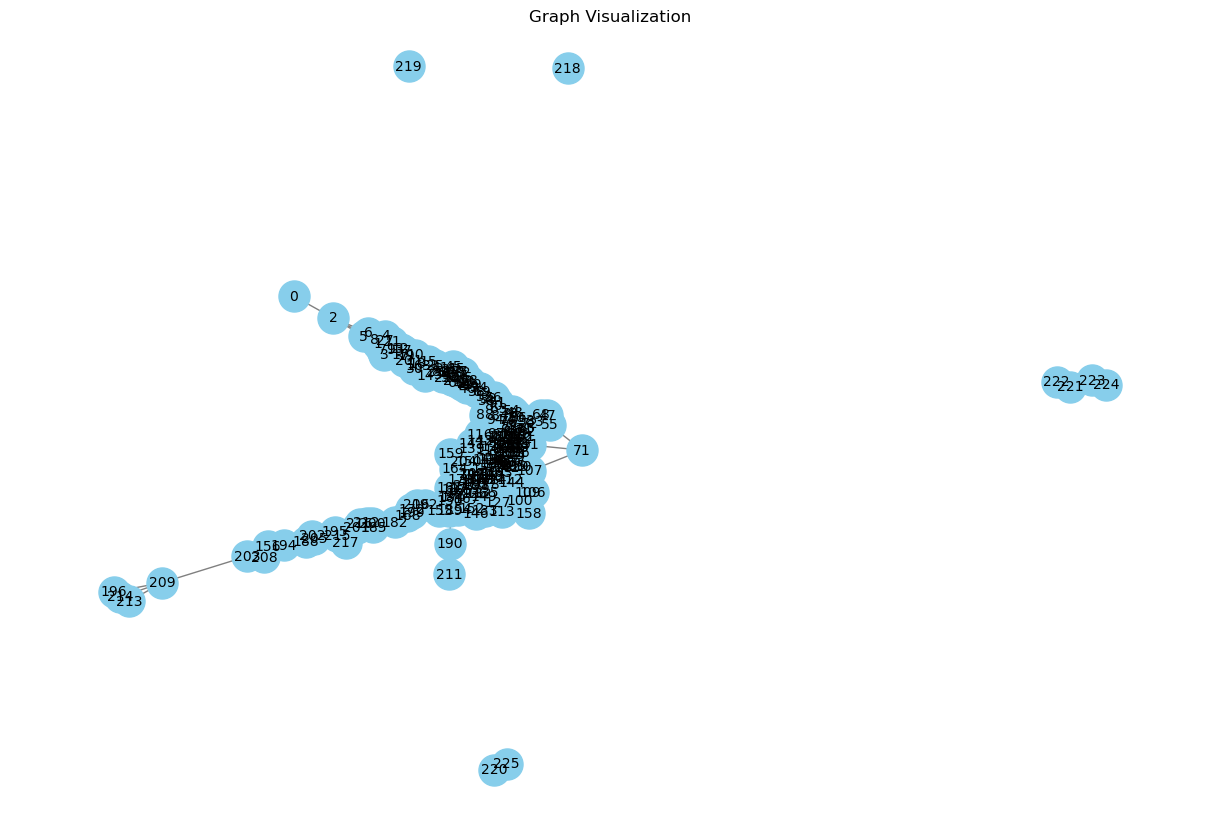

In [21]:
# Visualize the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G1)  # Layout for the nodes
nx.draw(G1, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=500, font_size=10)
plt.title("Graph Visualization")
plt.show()